In [1141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


#data = pd.read_csv(f"tweetsdata_16.csv")
data = pd.read_csv(f"test_dataset.csv")
#print(data)

In [1142]:
# main hastags to be used
main_hashtags = ['climatechange',
                'climatecrisis',
                'climatestrikeonline',
                'agw',
                'globalwarming',
                'savetheplanet',
                'climateemergency']

hashtags = []
individual_hashtags = []
for msg in data['Hashtags']:
    for hashtag in msg.split():
        tag = hashtag.strip('\'.,[]').lower().replace('\\', '').replace('/', '').replace(':', '')
        if "…" not in tag or "http" not in tag:
            hashtags.append(tag)
            if tag not in individual_hashtags:
                individual_hashtags.append(tag)
                
# all individual usernumbers per main hashtag
individual_users = dict.fromkeys(main_hashtags, [])

#number of tweets per main hashtag
num_of_tweets = dict.fromkeys(main_hashtags, 0)

# count of individual users per main hashtag
individual_users_count = dict.fromkeys(main_hashtags, 0)

users = data['Username']

for index, tweet_hashtags in enumerate(data['Hashtags']):
    for hashtag in main_hashtags:
        if hashtag in tweet_hashtags:
            num_of_tweets[hashtag] += 1
            if users[index] not in individual_users[hashtag]:
                individual_users[hashtag].append(users[index])
                individual_users_count[hashtag] += 1


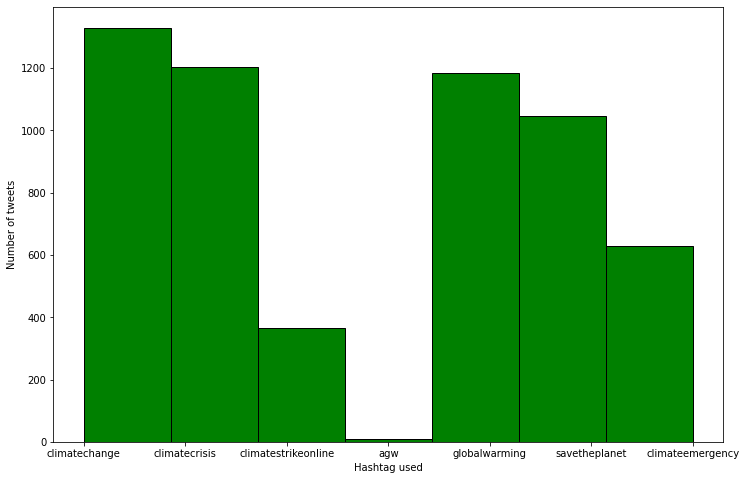

In [1143]:
#show number of tweets per hashtag
plt.figure(figsize=(12,8))
list = [key for key, val in num_of_tweets.items() for _ in range(val)]
plt.hist(list, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of tweets')
plt.xlabel('Hashtag used')
plt.show()

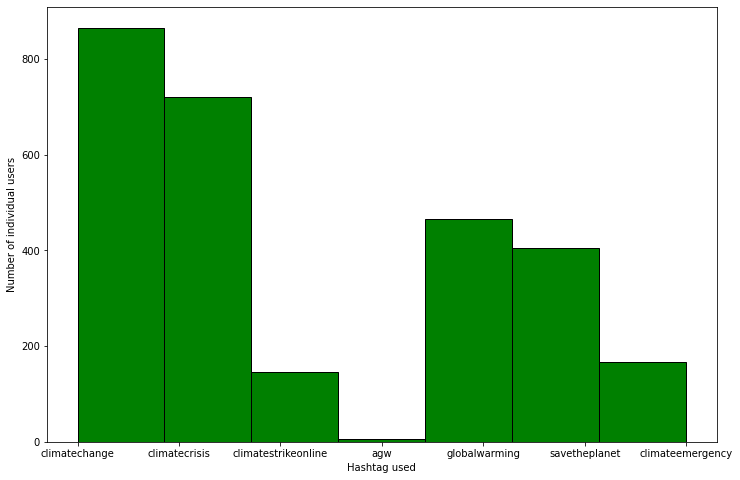

In [1144]:
#show number of users per hashtag
plt.figure(figsize=(12,8))
list = [key for key, val in individual_users_count.items() for _ in range(val)]
plt.hist(list, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of individual users')
plt.xlabel('Hashtag used')
plt.show()

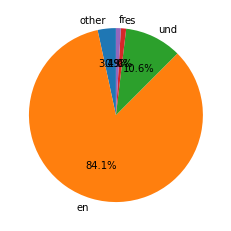

In [1145]:
# list of languages in tweets
languages = []
for tweet_lang in data['Language']:
    if tweet_lang not in languages:
        languages.append(tweet_lang)
        
# dict for number of tweets per language
lang_count = dict.fromkeys(languages, 0)

for tweet in data['Language']:
    for lang in languages:
        if lang in tweet:
            lang_count[lang] += 1

# sort dictionary by value
lang_count = dict(sorted(lang_count.items(), key=lambda item: item[1], reverse=True))

# labels dict for showing 5 most popular languages
# init 'other' to prevent keyerror
labels = {'other': 0}

for index, lang in enumerate(lang_count.keys()):
    if index >= 4:
        labels['other'] += lang_count[lang]
    else:
        labels[lang] = lang_count[lang]

fig1, ax1 = plt.subplots()
ax1.pie(labels.values(), labels=labels.keys(), autopct='%1.1f%%', startangle=90)

plt.show()

In [1146]:
#show geographic information of the tweets
from math import isnan

for index, g in enumerate(data['Geo']):
    try:
        g_is_nan = isnan(g)
    except TypeError:
        print(g)

{'place_id': '01e215db7136a37e'}
{'place_id': '06168d1feda43857'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': 'a0583a9994e6bf1b'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '219759301b4d8d23'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '18fe14b600b2c393'}
{'place_id': '4650a1e28c4d2dae'}
{'place_id': '74effb34539b2d64'}
{'place_id': '72606cdcf2847dd4'}
{'place_id': '5f55bb82cf16ac81'}
{'place_id': '5f55bb82cf16ac81'}
{'place_id': '0102ed48501a4846'}
{'place_id': '2cb13abdf90880ee'}
{'place_id': 'e7c97cdfef3a741a'}
{'place_id': 'f1d3a53f8a3cc7e9'}
{'place_id': '51ecc187876de86b'}
{'place_id': 'f1d3a53f8a3cc7e9'}
{'place_id': '07d9cdecf7886002'}
{'place_id': '009924a469d7ace1', 'coordinates': {'type': 'Point', 'coordinates': [-79.8996, -2.1761]}}
{'place_id': '009924a469d7ace1', 'coordinates': {'type': 'Point', 'coordinates': [-79.8996, -2.1761]}}
{'place_id': '3df4f427b5a60fea'}
{'place_id': '6a6d896ba1cb5dc4'}
{'

In [1147]:
#vader tool analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
vader_data = []
for sentence in data['Text']:
    vs = analyzer.polarity_scores(sentence)
    vader_data.append(vs)
    #print("{} {}".format(index, vs))
    
fig = px.scatter_ternary(vader_data, a="neg", b="neu", c="pos")
fig.show()

In [1153]:
#construct a social graph
import networkx as nx

G = nx.Graph()

# all_hashtags = ['climatechange',
#     'climatecrisis',
#     'climatestrikeonline',
#     'agw',
#     'globalwarming',
#     'savetheplanet',
#     'climateemergency']

# adjacent_nodes = {
#     'climatechange':[],
#     'climatecrisis': [],
#     'climatestrikeonline': [],
#     'agw': [],
#     'globalwarming': [],
#     'savetheplanet': [],
#     'climateemergency': []  
# }

adjacent_nodes = {}

for hashtag in individual_hashtags:
    G.add_node(hashtag)

for hashtag in individual_hashtags:
    adjacent_nodes[hashtag] = nx.algorithms.descendants(G, main_hashtags)

print(adjacent_nodes)

# #function for checking if there is an edge between nodes
# def check_adjacent(node, list_of_hashtags):
#     if 'agw' in list_of_hashtags and 'agw' != node:
#         if not 'agw' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['agw']

#     if 'climatechange' in list_of_hashtags and 'climatechange' != node:
#         if not 'climatechange' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['climatechange']

#     if 'climatecrisis' in list_of_hashtags and 'climatecrisis' != node:
#         if not 'climatecrisis' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['climatecrisis']

#     if 'climatestrikeonline' in list_of_hashtags and 'climatestrikeonline' != node:
#         if not 'climatestrikeonline' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['climatestrikeonline']

#     if 'globalwarming' in list_of_hashtags and 'globalwarming' != node:
#         if not 'globalwarming' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['globalwarming']

#     if 'savetheplanet' in list_of_hashtags and 'savetheplanet' != node:
#         if not 'savetheplanet' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['savetheplanet']

#     if 'climateemergency' in list_of_hashtags and 'climateemergency' != node:
#         if not 'climateemergency' in adjacent_nodes[node]:
#             adjacent_nodes[node] += ['climateemergency']

# #go through all the tweets and check if there should be edge between certain hashtags
# for tweet in data['Hashtags']:
#     if 'agw' in tweet:
#         check_adjacent('agw', tweet)
#     if 'climatechange' in tweet:
#         check_adjacent('climatechange', tweet)
#     if 'climatecrisis' in tweet:
#         check_adjacent('climatecrisis', tweet)
#     if 'climatestrikeonline' in tweet:
#         check_adjacent('climatestrikeonline', tweet)
#     if 'globalwarming' in tweet:
#         check_adjacent('globalwarming', tweet)
#     if 'savetheplanet' in tweet:
#         check_adjacent('savetheplanet', tweet)
#     if 'climateemergency' in tweet:
#         check_adjacent('climateemergency', tweet)
    
#print(adjacent_nodes)

#add all the hashtags as nodes to the graph
# for tag in all_hashtags:
#     G.add_node(tag)
    
#add all the necessary edges with the help of adjacent_nodes dictionary
for node in adjacent_nodes:
    for i in range(len(adjacent_nodes[node])):
        #print(node, adjacent_nodes[node][i])
        G.add_edge(node, adjacent_nodes[node][i])


#nx.draw(G, with_labels=False)

NetworkXError: The node ['climatechange', 'climatecrisis', 'climatestrikeonline', 'agw', 'globalwarming', 'savetheplanet', 'climateemergency'] is not in the graph.

In [1149]:
#calculate main global properties of the graph
# number of nodes in variable
num_nodes = G.number_of_nodes()
# number of edges in variable 
num_edges = G.number_of_edges()
# degree centrality in a variable
degree_centrality = nx.degree_centrality(G)

degree_sum = 0
# average degree centrality
average_degree_centrality = sum(degree_centrality.values())/num_nodes

try:
        dia = nx.diameter(G)
except nx.NetworkXError:
        pass

clustering_coefficient = nx.average_clustering(G)

# size of the largest component
components = [x for x in nx.connected_components(G)]
largest_component = max(components, key=len)

data = {'Number of nodes': num_nodes,
        'Number of edges': num_edges,
        'Average degree centrality': average_degree_centrality,
        'Diameter': dia,
        'Clustering coefficient': clustering_coefficient,
        'Size of largest component': len(largest_component)}

main_properties_dataframe = pd.DataFrame(data, index=['-'])
print(main_properties_dataframe)

   Number of nodes  Number of edges  Average degree centrality  Diameter  \
-             4201                0                        0.0         2   

   Clustering coefficient  Size of largest component  
-                     0.0                          1  


In [1151]:
# Plot the degree distribution and local clustering coeffisient distribution
# degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
# local_clustering_sequence = sorted(nx.clustering(G).values(), reverse=True)
# dmax = max(degree_sequence)
# cmax = max(local_clustering_sequence)

degree_sequence = sorted(G.degree(), key=lambda x: x[1], reverse=True)
local_clustering_sequence = sorted(nx.clustering(G).values(), reverse=True)


fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.hist(degree_sequence)
ax1.set_title("Degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("# of nodes")

ax2 = fig.add_subplot(122)
ax2.hist(local_clustering_sequence)
ax2.set_title("Local Clustering Coefficient Distribution")
ax2.set_xlabel("Local Clustering Coefficient")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
# label propagation algorithm for finding communities
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
print([x for x in communities])

[{'climatechange'}, {'climatecrisis'}, {'industrialization'}, {'pesticides'}, {'agriculture'}, {'usanewsheadlines'}, {'globalwarming'}, {'useconomy'}, {'greenhousegas'}, {'carboncapture'}, {'careexperience'}, {'climateaction'}, {'water'}, {'drought'}, {'flood'}, {'esg'}, {'environment'}, {'dayzero'}, {'heat'}, {'nature'}, {'future'}, {'sustainability'}, {'worldwewant'}, {'plasticstreaty'}, {'pla…'}, {'extinctionrebellion'}, {'climateemergency'}, {'costoflivincrisis'}, {'jacobreesmogg'}, {'twitter'}, {'socialmedia'}, {'ban'}, {'advertisements'}, {'technews'}, {'ai'}, {'esgstrategy'}, {'esgreporting'}, {'sustainabilitymatters'}, {'governance'}, {'esgtargets'}, {'netzero'}, {'sustainabilityconsulting'}, {'kmc'}, {'mhpss'}, {'climateemergency?'}, {'climateactionnow'}, {'breedingseason'}, {'cultists'}, {'lnpcorruptionparty'}, {'netherlands?'}, {'podcast'}, {'mondaythoughts'}, {'mondayvibes'}, {'plastic'}, {'plasticpollution'}, {'solutions'}, {'saveearth'}, {'savetheplanet'}, {'savesoilsavel